# FashionMNIST CNN Classification

## import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from torchsummary import summary
import torch.nn.functional as F
import torch
import torch.optim as optim

## parameters

In [14]:
batch_size = 24
learning_rate = 0.001
epochs = 100
momentum= 0.9

optimizer = optim.SGD
criterion = nn.CrossEntropyLoss

## load dataset

In [3]:
# transform to read data as tensor
transform = transforms.ToTensor()

#  torchvision datasets are PILImage images of range [0, 1].
train_data = FashionMNIST(root= "./data", train= True, download= True, transform= transform)
test_data = FashionMNIST(root= "./data", train= False, download= True, transform= transform)

train_loader = DataLoader(train_data, batch_size= batch_size, shuffle= True)
test_loader = DataLoader(test_data, batch_size= batch_size, shuffle= True)

print("train data size:",len(train_data))
print("test data size:",len(test_data))

print("train loader size:",len(train_loader))
print("train loader size:",len(test_loader))


# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.4MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 232kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 4.28MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 18.6MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

train data size: 60000
test data size: 10000
train loader size: 2500
train loader size: 417


Image Shape:  (24, 1, 28, 28)
Label:  [3 2 9 1 4 8 4 1 0 0 8 4 7 7 6 2 0 9 3 2 6 4 5 8]


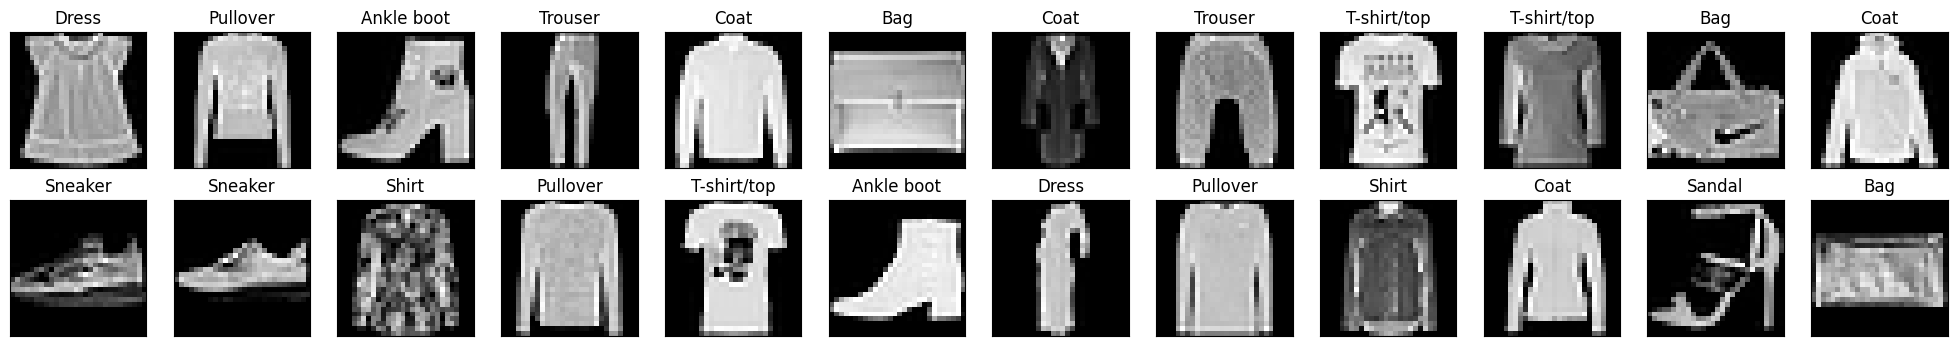

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter._next_data()
images = images.numpy()
print('Image Shape: ', images.shape)
print('Label: ', labels.numpy())
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

# cnn architecture

In [5]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    # (w-f+2p)/s+1
    # (28-3 + (2*0))/1 +1 = 26
    # out_put = (32, 26, 26)

    self.relu1 = F.relu

    # kernel 2 , stride 2
    self.pool1 = nn.MaxPool2d(2,2)
    # out_put = (32, 13, 13)

    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    # output shape = (64, 11, 11)

    self.relu2 = F.relu

    self.pool2 = nn.MaxPool2d(2,2)
    # output shape = (64, 5, 5)

    # 64 output with 5*5 filtered/pool mapsize
    # 10 output channel
    self.fc1 = nn.Linear(64*5*5, 50)
    self.relu3= F.relu
     # dropout with p=0.4
    self.fc1_drop = nn.Dropout(p=0.4)
    # finally, create 10 output channels (for the 10 classes)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.pool2(x)
    # Flatten
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.relu3(x)
    x = self.fc1_drop(x)
    x = self.fc2(x)
    return x


In [6]:
model = Net()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
         MaxPool2d-2           [-1, 32, 13, 13]               0
            Conv2d-3           [-1, 64, 11, 11]          18,496
         MaxPool2d-4             [-1, 64, 5, 5]               0
            Linear-5                   [-1, 50]          80,050
           Dropout-6                   [-1, 50]               0
            Linear-7                   [-1, 10]             510
Total params: 99,376
Trainable params: 99,376
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.28
Params size (MB): 0.38
Estimated Total Size (MB): 0.66
----------------------------------------------------------------


## train network

In [15]:
# using cross entropy whcih combines softmax and NLL loss
optimizer = optimizer(model.parameters(), lr= learning_rate, momentum= momentum)
# stochastic gradient descent with a small learning rate AND some momentum
criterion = criterion()

In [16]:
# calculate accuracy before training
correct = 0
total = 0

for images, labels in test_loader:
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
accuracy = 100 * correct / total
print('Accuracy of the network before training: %d %%' % (accuracy))

Accuracy of the network before training: 10 %


In [19]:
def train(epoches):
  # track losses
  loss_over_time = []
  running_loss = 0.0

  for epoch in range(epoches):
    for batch_idx, (images, labels) in enumerate(train_loader):
      # zero the parameter (weight) gradients
      optimizer.zero_grad()
      output = model(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      if batch_idx % 1000 == 999:    # print every 1000 batches
        avg_loss = running_loss/1000
        # record and print the avg loss over the 1000 batches
        loss_over_time.append(avg_loss)
        print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_idx+1, avg_loss))
        running_loss = 0.0
  print('Finished Training')
  return loss_over_time


In [20]:
n_epochs = 30 # start small to see if your model works, initially

# call train
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 1.5895256443619727
Epoch: 1, Batch: 2000, Avg. Loss: 0.9706428063213826
Epoch: 2, Batch: 1000, Avg. Loss: 1.2141962611973285
Epoch: 2, Batch: 2000, Avg. Loss: 0.7251651131659747
Epoch: 3, Batch: 1000, Avg. Loss: 1.0101587132811547
Epoch: 3, Batch: 2000, Avg. Loss: 0.6358349915444851
Epoch: 4, Batch: 1000, Avg. Loss: 0.9172803149372339
Epoch: 4, Batch: 2000, Avg. Loss: 0.5724731939733029
Epoch: 5, Batch: 1000, Avg. Loss: 0.8245188756138087
Epoch: 5, Batch: 2000, Avg. Loss: 0.5379742683544755
Epoch: 6, Batch: 1000, Avg. Loss: 0.7750886555761098
Epoch: 6, Batch: 2000, Avg. Loss: 0.5105562148094177
Epoch: 7, Batch: 1000, Avg. Loss: 0.7378289505317808
Epoch: 7, Batch: 2000, Avg. Loss: 0.4765600275620818
Epoch: 8, Batch: 1000, Avg. Loss: 0.6987863879837096
Epoch: 8, Batch: 2000, Avg. Loss: 0.4555944561213255
Epoch: 9, Batch: 1000, Avg. Loss: 0.6681045914813876
Epoch: 9, Batch: 2000, Avg. Loss: 0.4360205042734742
Epoch: 10, Batch: 1000, Avg. Loss: 0.649385078

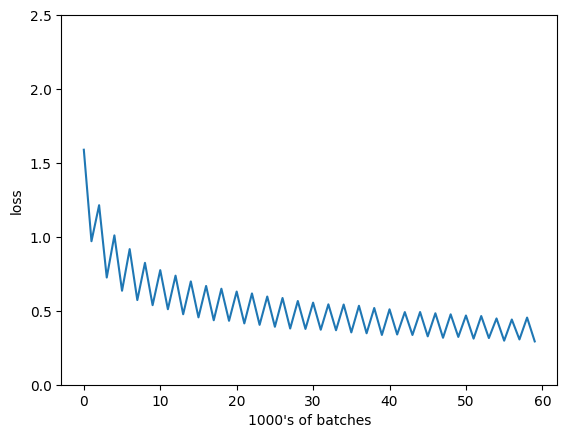

In [21]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

## test the trained network

In [29]:
test_loss = torch.zeros(1)
class_correct = np.ones((10,1))
class_total = np.ones((10,1))

model.eval()

for batch_idx, (images,labels) in enumerate(test_loader):
  output = model(images)
  loss = criterion(output, labels)
  # update average test loss
  test_loss = test_loss + ((torch.ones(1) / (batch_idx + 1)) * (loss.data - test_loss))

  _, predicted = torch.max(output.data, 1)

  # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
  correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))

  # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
  for i in range(batch_size):
    if (batch_size != len(labels.data) and len(labels.data) == i ): break # out of batch index for last batch
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i],
            100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]),
            np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct),
    np.sum(class_total)))

Test Loss: 0.288172

Test Accuracy of T-shirt/top: 85% (856/1001)
Test Accuracy of Trouser: 98% (981/1001)
Test Accuracy of Pullover: 86% (868/1001)
Test Accuracy of Dress: 90% (908/1001)
Test Accuracy of  Coat: 84% (847/1001)
Test Accuracy of Sandal: 98% (982/1001)
Test Accuracy of Shirt: 65% (653/1001)
Test Accuracy of Sneaker: 97% (975/1001)
Test Accuracy of   Bag: 97% (979/1001)
Test Accuracy of Ankle boot: 94% (943/1001)

Test Accuracy (Overall): 89% (8992/10010)


<ipython-input-29-ad017471e741>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (


## test datas

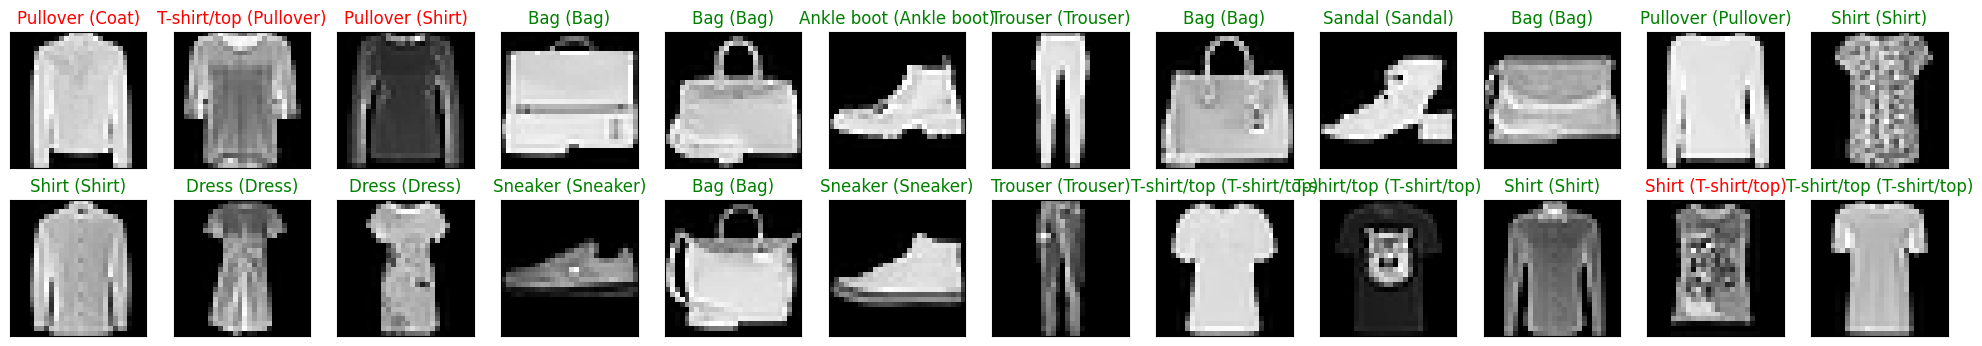

In [30]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter._next_data()
# get predictions
preds = np.squeeze(model(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [32]:
# Saving the model
! mkdir saved_models

model_dir = 'saved_models/'
model_name = 'fashion_net_ex.pt'


# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
torch.save(model.state_dict(), model_dir+model_name)

In [33]:
from google.colab import files
import zipfile

!zip -r saved_models.zip saved_models

files.download('saved_models.zip')

  adding: saved_models/ (stored 0%)
  adding: saved_models/fashion_net_ex.pt (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

for more:
https://github.com/SoheilSedghi/Few-Parameters-for-CIFAR-10-Classification